In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
from sklearn.cluster import KMeans

In [2]:
torch.manual_seed(42)
np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 2
DATASET_CLUSTER_COUNT = 5
DATASET_R = 20

In [3]:
from kneed import KneeLocator

def kmeans_elbow(dataset, cap=25):
    lim = min(int(np.sqrt(len(dataset))), cap)
    K = range(1, lim)
    inertias = []

    for k in K:
        kmeans = KMeans(n_clusters=k).fit(dataset)
        inertias.append(kmeans.inertia_)

    kl = KneeLocator(K, inertias, curve="convex", direction="decreasing")
    return kl.elbow

Samplers

In [4]:
# DO I KEEP THIS THOUGH
# also torch.utils.data.Sampler exists -> put it in dataloader constructor
from torch.utils.data import Sampler, RandomSampler
from collections.abc import Sized, Iterator
from abc import ABC, abstractmethod

class ClusterSampler(Sampler):
    def __init__(self, data_source:Sized, batch_size):
        ideal_k = kmeans_elbow(data_source)
        kmeans_res = KMeans(n_clusters=ideal_k).fit(data_source)
        self.cluster_count = ideal_k
        self.clusters = [np.array([], dtype=np.uint32) for _ in range(self.cluster_count)]
        for i, l in enumerate(kmeans_res.labels_):
            self.clusters[l] = np.append(self.clusters[l], i)

        self.num_samples = len(data_source)
        self.batch_size = batch_size

        self.sample_count = [len(self.clusters[i])*batch_size//self.num_samples
                             for i in range(self.cluster_count)]

        self.added_count = self.batch_size - sum(self.sample_count)
        self.added_probs =  np.array([len(self.clusters[i])*batch_size%self.num_samples
                             for i in range(self.cluster_count)], dtype=np.float64)
        self.added_probs /= np.sum(self.added_probs)

        # we miss num_samples % batch_size elements in the process so we add them back
        self.last_batch_size = self.num_samples%self.batch_size
        self.last_sample_count = [len(self.clusters[i])*self.last_batch_size//self.num_samples
                                  for i in range(self.cluster_count)]
        self.last_added_count = self.last_batch_size - sum(self.last_sample_count)
        self.last_added_probs =  np.array([len(self.clusters[i])*self.last_batch_size%self.num_samples
                             for i in range(self.cluster_count)], dtype=np.float64)
        self.last_added_probs /= np.sum(self.last_added_probs)

    def __iter__(self) -> Iterator[int]:
        
        for _ in range(self.num_samples//self.batch_size):
            added = np.random.choice(self.cluster_count, self.added_count, p=self.added_probs)
            sample_count = self.sample_count[:]
            for i_added in added:
                sample_count[i_added] += 1
            
            for i_cluster in range(self.cluster_count):
                selected = np.random.choice(self.clusters[i_cluster], sample_count[i_cluster])
                yield from selected
                
        added = np.random.choice(self.cluster_count, self.last_added_count, p=self.last_added_probs)
        sample_count = self.last_sample_count[:]
        for i_added in added:
            sample_count[i_added] += 1
        
        for i_cluster in range(self.cluster_count):
            selected = np.random.choice(self.clusters[i_cluster], sample_count[i_cluster])
            yield from selected


In [5]:
from torch import nn
import copy

class LogisticModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=False)
        self.layer.weight.data.fill_(3)
    
    def forward(self, ai):
        x = self.layer(ai)
        res = torch.log(1 + torch.exp(x))
        return res.flatten()
    
def logit_criterion(output, batch):
    return output.mean()

In [6]:
from sklearn.datasets import make_blobs
clustered_data,_ = make_blobs(n_samples=DATASET_SIZE, 
                              n_features=DATASET_DIM,
                              centers=DATASET_CLUSTER_COUNT,
                              random_state=42)
clustered_data = clustered_data.astype(np.float32)

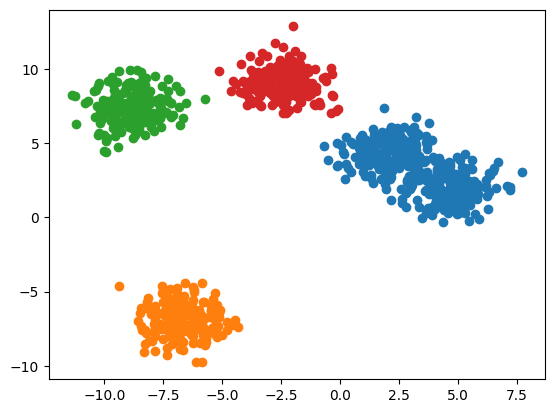

In [7]:
sampler = ClusterSampler(clustered_data, 64)
for i in range(sampler.cluster_count):
    selected = clustered_data[sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
plt.show()

Displaying what the clusters look like after evaluating the gradients

Solvers

In [8]:
# https://realpython.com/documenting-python-code/

from tqdm import tqdm

def solve_problem(model, #model_builder,
                  criterion,
                  optimizer_class,
                  dataloader,
                  epoch_count: int=100, 
                  verbose=False):
    
    if verbose:
        print("Building models...")
    # model = model_builder(dataset)
    optimizer = optimizer_class(model.parameters())

    loss_hist = np.zeros(epoch_count)
    for i in tqdm(range(epoch_count)):
        for batch in dataloader:
            output = model(batch)
            loss = criterion(output, batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_hist[i] = loss
    
    return model, loss_hist

In [9]:
from utils import clone_model

In [10]:
def calc_grad(model:nn.Module, data, target, loss_function):
    """
    Function to compute the grad
    args : data, target, loss_function
    return loss
    """
    outputs = model(data)
    loss = loss_function(outputs, target)
    loss.backward() #compute grad
    return loss

In [11]:
from math import ceil

def svrg(model:nn.Module,
         loss_function,
         dataloader:DataLoader,
         *model_args,
         n_epoch,
         learning_rate=0.001, # for correspondance with torch.optim function 
         print_freq=None):
    """
    Function to updated weights with a SVRG backpropagation \\
    args : dataset, loss function, number of epochs, learning rate \\
    return : total_loss_epoch
    """
    n_samples = len(dataloader.dataset)
    # n_epoch = wanted_iter_count // ceil(n_samples/batch_size) + 1
    total_loss_epoch = [0] * n_epoch
    dataset = torch.from_numpy(dataloader.dataset)

    for epoch in tqdm(range(n_epoch)):
        running_loss = 0.0
        previous_net = clone_model(model, *model_args) # for calculating gradient each step
        
        #Compute full grad
        previous_net.zero_grad()
        total_loss_epoch[epoch] \
            = calc_grad(previous_net, dataset, None, loss_function).item()
        
        previous_net_grads = [p.grad.data for p in previous_net.parameters()]
        # print(total_loss_epoch[epoch])

        #Run over the dataset
        for i_data, batch in enumerate(dataloader):

            #Compute prev stoc grad
            previous_net.zero_grad() #grad = 0
            prev_loss = calc_grad(previous_net, batch, None, loss_function)
            
            #Compute cur stoc grad
            model.zero_grad() #grad = 0
            cur_loss = calc_grad(model, batch, None, loss_function)
            
            #Backward
            for param1, param2, param3 in zip(model.parameters(), previous_net.parameters(), previous_net_grads): 
                # print(param1.data, (param1.grad.data - param2.grad.data + (1./n_samples) * param3))
                param1.data.sub_((learning_rate) * (param1.grad.data - param2.grad.data + param3))


            # print statistics
            running_loss += cur_loss.item()
            if print_freq and i_data % print_freq == print_freq-1:
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i_data + 1, running_loss / print_freq))
                running_loss = 0.0
            
    return model, total_loss_epoch

In [12]:
def COVER(model:nn.Module,
         loss_function,
         dataloader:DataLoader,
         *model_args,
         n_epoch,
         learning_rate=0.001, # for correspondance with torch.optim function
         ):
    """
    See COVER: a cluster-based variance reduced method for online learning (Yuan et al. 2019)
    """
    assert dataloader.batch_size == 1, "Error, batch size needs to be 1"

    total_loss_epoch = [0] * n_epoch
    dataset = torch.from_numpy(dataloader.dataset)

    cluster_count = kmeans_elbow(dataset)
    kmeans_res = KMeans(n_clusters=cluster_count).fit(dataset)
    # needed?
    # clusters = [np.array([], dtype=np.uint32) for _ in range(cluster_count)]
    cluster_sizes = np.zeros(cluster_count)
    for i, l in enumerate(kmeans_res.labels_):
        # clusters[l] = np.append(clusters[l], i)
        cluster_sizes[l] += 1

    cluster_lr = learning_rate / cluster_sizes

    g_cluster = [torch.zeros_like(model.parameters()) for _ in range(cluster_count)] # TODO: FIX THIS
    g_bar = torch.zeros_like()

    for epoch in tqdm(range(n_epoch)):
        # running_loss = 0
        for batch in dataloader:
            model.zero_grad()
            loss = calc_grad(model, batch, "", loss_function)
            curr_cluster = kmeans_res.labels_[batch] # TODO
            # check if reference passed or just copy...
            for param, g_c, g_b in zip(model.parameters(), g_cluster[curr_cluster], g_bar):
                grad = param.grad.data
                param.data.sub_(learning_rate*(grad - g_c + g_b))
                g_c.add_(cluster_lr[curr_cluster]*(g_c - grad))
                g_b.add_(learning_rate*(g_c - grad))

    return model, total_loss_epoch

In [13]:
NB_EPOCH = 300
BATCH_SIZE = 64

In [14]:
base_model = LogisticModel(clustered_data)

In [15]:
_, svrg_sol = svrg(clone_model(base_model, clustered_data),
                logit_criterion,
                DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                # learning_rate=0.001,
                print_freq=None)

100%|██████████| 300/300 [00:04<00:00, 63.35it/s]


In [16]:
from utils import clone_model

In [17]:
opt_model, sgd_sol = solve_problem(clone_model(base_model, clustered_data), 
              logit_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 92.96it/s] 


In [18]:
_, adam_sol = solve_problem(clone_model(base_model, clustered_data), 
              logit_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 80.94it/s]


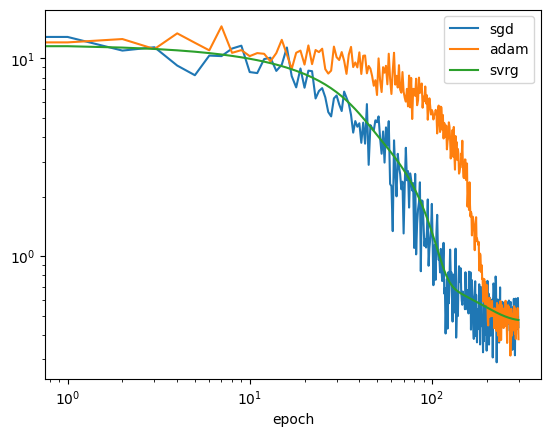

In [19]:
plt.plot(sgd_sol, label="sgd")
plt.plot(adam_sol, label="adam")
plt.plot(svrg_sol, label="svrg")
plt.xlabel("epoch")
plt.legend()
plt.loglog()
plt.show()

In [20]:
iid_sampler = RandomSampler(clustered_data, replacement=True)
iid_dataloader = DataLoader(clustered_data, BATCH_SIZE, sampler=iid_sampler)

In [21]:
_, adam_sol_iid = solve_problem(clone_model(base_model, clustered_data), 
              logit_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=iid_dataloader,
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 81.60it/s]


In [22]:
cluster_sampler = ClusterSampler(clustered_data, BATCH_SIZE)
cluster_dataloader = DataLoader(clustered_data, BATCH_SIZE, sampler=iid_sampler)

In [23]:
_, adam_sol_cluster = solve_problem(clone_model(base_model, clustered_data), 
              logit_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=cluster_dataloader,
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 82.45it/s]


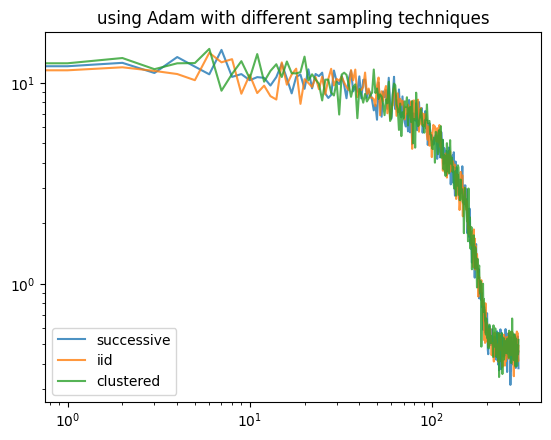

In [24]:
plt.plot(adam_sol, label="successive", alpha=0.8)
plt.plot(adam_sol_iid, label="iid", alpha=0.8)
plt.plot(adam_sol_cluster, label="clustered", alpha=0.8)
plt.legend()
plt.loglog()
plt.title("using Adam with different sampling techniques")
plt.show()

In [26]:
_, sgd_sol_iid = solve_problem(clone_model(base_model, clustered_data), 
              logit_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=iid_dataloader,
              epoch_count=NB_EPOCH,
              verbose=True)

_, sgd_sol_cluster = solve_problem(clone_model(base_model, clustered_data), 
              logit_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=cluster_dataloader,
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 91.24it/s]


Building models...


100%|██████████| 300/300 [00:03<00:00, 89.63it/s]


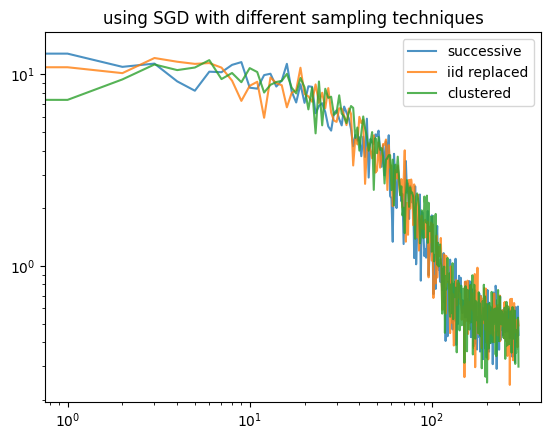

In [27]:
plt.plot(sgd_sol, label="successive", alpha=0.8)
plt.plot(sgd_sol_iid, label="iid replaced", alpha=0.8)
plt.plot(sgd_sol_cluster, label="clustered", alpha=0.8)
plt.legend()
plt.loglog()
plt.title("using SGD with different sampling techniques")
plt.show()

In [28]:
def get_grad(batch, model):
    ret = np.zeros((len(batch), 2))
    for i, elem in enumerate(batch):
        res = model(elem)
        l = logit_criterion(res, "")
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

def display_grads(dataset, model, title=""):
    dataset_torch = torch.from_numpy(dataset)
    for i in range(sampler.cluster_count):
        selected = dataset_torch[sampler.clusters[i]]
        grad_selected = get_grad(selected, model)
        plt.scatter(grad_selected[:,0], grad_selected[:,1], alpha=0.5)

    plt.title(title)
    plt.show()

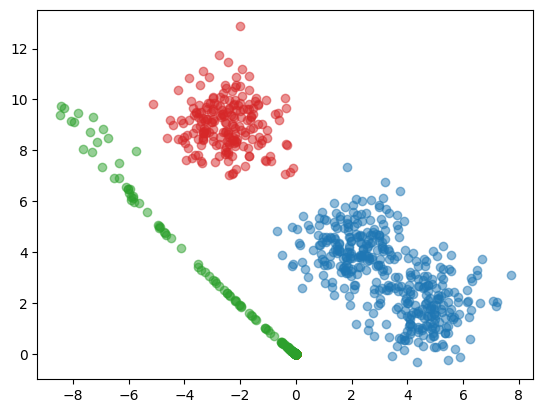

In [29]:
display_grads(clustered_data, base_model)

Building models...


100%|██████████| 80/80 [00:00<00:00, 91.19it/s]


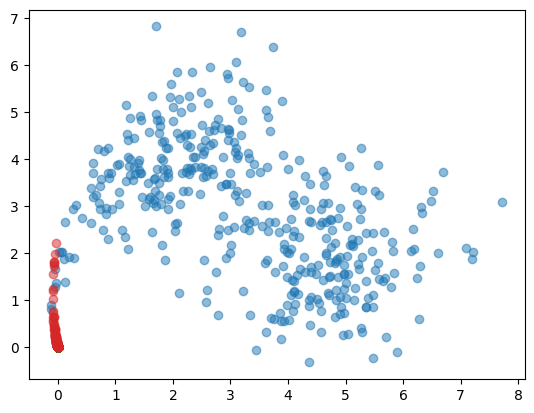

In [30]:
model, _ = solve_problem(clone_model(base_model, clustered_data), 
                        logit_criterion,
                        optimizer_class=torch.optim.SGD,
                        dataloader=DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
                        epoch_count=80,
                        verbose=True)
display_grads(clustered_data, model)

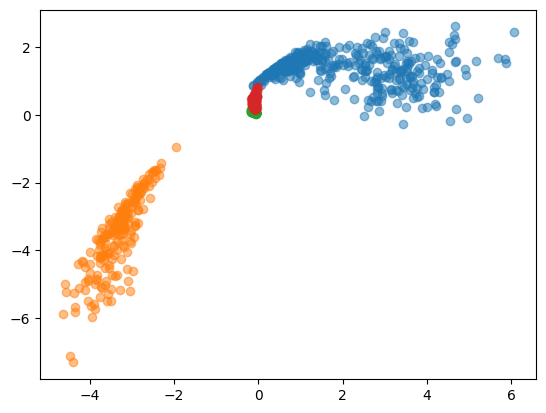

In [31]:
display_grads(clustered_data, opt_model)